Mia Sowder

In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   # matplolib pyplot module as "plt"
import seaborn as sns             # seaborn as "sns"
import sqlite3



# Function to store sentiments of the sentence from a comments table
def comment_sentiment_scores(sentence, table):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    # polarity_scores method of SentimentIntensityAnalyzer object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    cur.execute(f"""
    UPDATE {table}
    SET comment_vader_negative_sentiment = ?, 
        comment_vader_neutral_sentiment = ?, 
        comment_vader_positive_sentiment = ?, 
        comment_vader_compound_sentiment = ?
    WHERE comment_body = ?
    """, 
    (sentiment_dict['neg'], 
     sentiment_dict['neu'], 
     sentiment_dict['pos'], 
     sentiment_dict['compound'], 
     sentence))
    
    conn.commit() 

# Function to store sentiments of the sentence from posts table
def post_sentiment_scores(post_title, post_body, table):

    sentence = post_title + post_body    
    
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    # polarity_scores method of SentimentIntensityAnalyzer object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    cur.execute(f"""
    UPDATE {table}
    SET post_vader_negative_sentiment = ?, 
        post_vader_neutral_sentiment = ?, 
        post_vader_positive_sentiment = ?, 
        post_vader_compound_sentiment = ?
    WHERE post_body = ?
    """, 
    (sentiment_dict['neg'], 
     sentiment_dict['neu'], 
     sentiment_dict['pos'], 
     sentiment_dict['compound'], 
     post_body ))
    
    conn.commit() 
    
# Driver code to test the function
if __name__ == "__main__" :
    
    with sqlite3.connect('raam_database.db') as conn:
        cur = conn.cursor()
        tables = ["nursing_comments", "nursing_posts", 
                  "teaching_comments", "teaching_posts",
                  "health_anxiety_comments", "health_anxiety_posts"]
        for table in tables:
            table_type = table.split('_')
            table_type = table_type[-1]
            
            df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
            
            for index, row in df.iterrows():
                if table_type == "comments":
                    sentence = row[3]
                    comment_sentiment_scores(sentence, table)
                elif table_type == "posts":
                    post_title = row[3]
                    post_body = row[4]
                    post_sentiment_scores(post_title, post_body, table)
                else:
                    raise "ERROR fetching table type"
                

/var/folders/hr/wd6z7xjs1cv5v4pw0v06v7vm0000gn/T/ipykernel_14347/2229840853.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentence = row[3]
/var/folders/hr/wd6z7xjs1cv5v4pw0v06v7vm0000gn/T/ipykernel_14347/2229840853.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  post_title = row[3]
/var/folders/hr/wd6z7xjs1cv5v4pw0v06v7vm0000gn/T/ipykernel_14347/2229840853.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  post_body =

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to SQLite
conn = sqlite3.connect('raam_database.db')

# Read data into a Pandas DataFrame
df = pd.read_sql_query("SELECT * FROM teaching_comments", conn)

# Close the connection
conn.close()


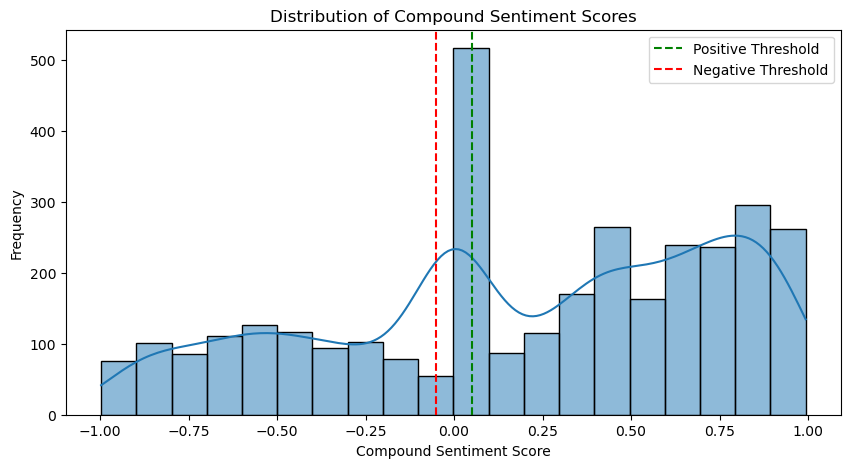

In [3]:
#Sentiment Score Distribution (Histogram)

plt.figure(figsize=(10, 5))
sns.histplot(df['comment_vader_compound_sentiment'], bins=20, kde=True)
plt.axvline(0.05, color='g', linestyle='--', label="Positive Threshold")
plt.axvline(-0.05, color='r', linestyle='--', label="Negative Threshold")
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Compound Sentiment Scores')
plt.legend()
plt.show()

/var/folders/hr/wd6z7xjs1cv5v4pw0v06v7vm0000gn/T/ipykernel_14347/72693301.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x='Sentiment Type', y='Sentiment Score', estimator=sum, ci=None)


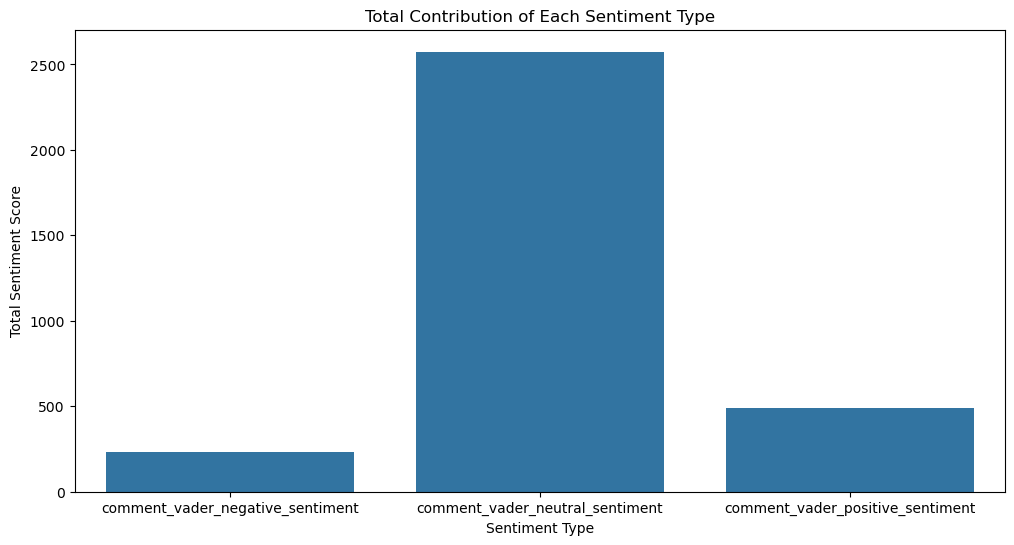

In [4]:
#Sentiment Breakdown (Stacked Bar Plot)

df_melted = df.melt(id_vars=['comment_id'], 
                     value_vars=['comment_vader_negative_sentiment', 
                                 'comment_vader_neutral_sentiment', 
                                 'comment_vader_positive_sentiment'],
                     var_name="Sentiment Type",
                     value_name="Sentiment Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Sentiment Type', y='Sentiment Score', estimator=sum, ci=None)
plt.ylabel('Total Sentiment Score')
plt.title('Total Contribution of Each Sentiment Type')
plt.show()

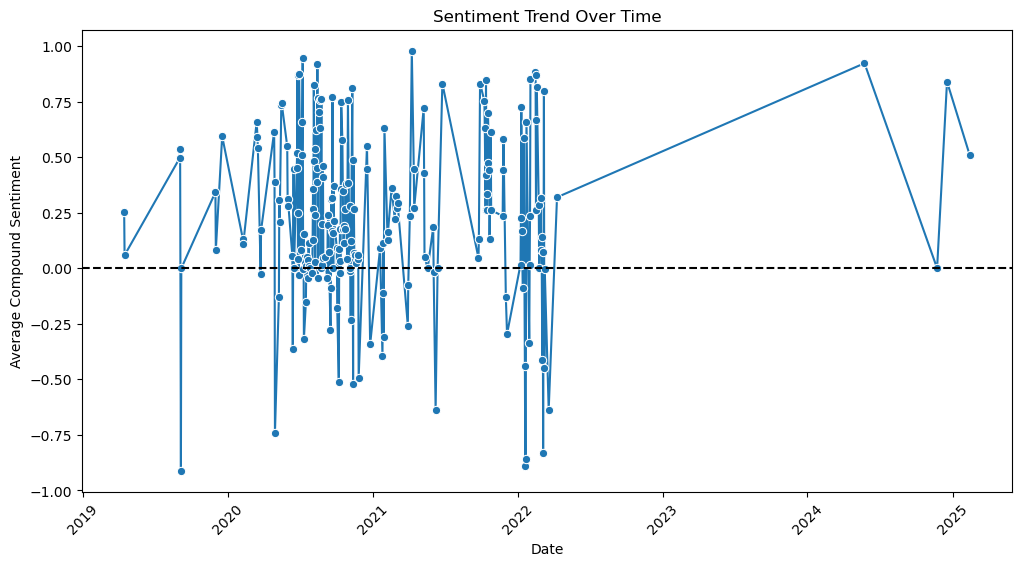

In [5]:
#Sentiment Trends Over Time

# Convert timestamp to datetime format
df['comment_timestamp'] = pd.to_datetime(df['comment_timestamp'])

# Aggregate sentiment over time
df_time = df.groupby(df['comment_timestamp'].dt.date)['comment_vader_compound_sentiment'].mean().reset_index()

# Plot time series
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_time, x='comment_timestamp', y='comment_vader_compound_sentiment', marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average Compound Sentiment')
plt.title('Sentiment Trend Over Time')
plt.xticks(rotation=45)
plt.show()

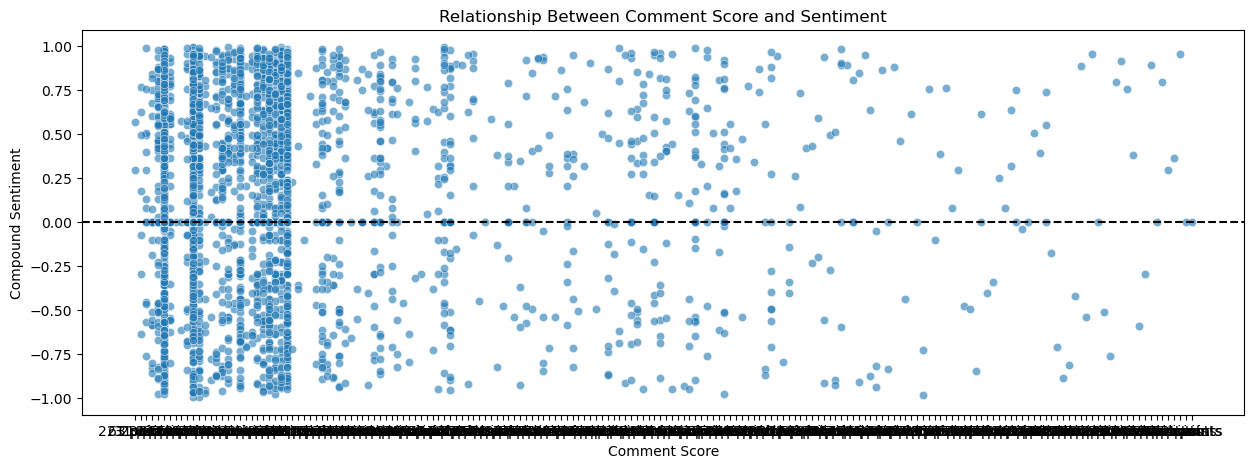

In [7]:
#Comment Score vs. Sentiment (Scatter Plot)

plt.figure(figsize=(15, 5))
sns.scatterplot(data=df, x='comment_score', y='comment_vader_compound_sentiment', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comment Score')
plt.ylabel('Compound Sentiment')
plt.title('Relationship Between Comment Score and Sentiment')
plt.show()

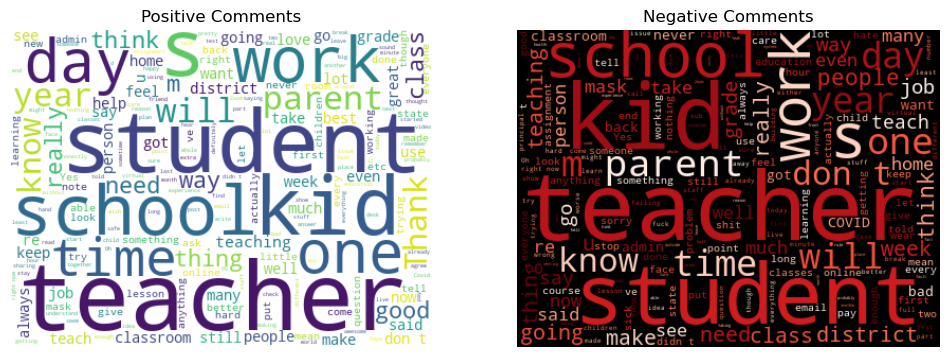

In [9]:
# Word Clouds for Positive and Negative Sentiments

from wordcloud import WordCloud

# Separate positive and negative comments
positive_comments = " ".join(df[df['comment_vader_compound_sentiment'] > 0.05]['comment_body'])
negative_comments = " ".join(df[df['comment_vader_compound_sentiment'] < -0.05]['comment_body'])

# Generate word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=400, height=300, background_color='white').generate(positive_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Comments")

plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=400, height=300, background_color='black', colormap='Reds').generate(negative_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Comments")

plt.show()
